### Packages needed 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import rasterio
import fiona
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
import rasterio.mask
import datetime 
import gdal
from matplotlib.offsetbox import AnchoredText

### Functions 

In [2]:
def chunks(lst, n):
    """Yield successive n-sized chunks from list."""
    lst=lst.tolist()
    K=[]
    
    for i in range(0, len(lst), n):
        K.append(lst[i:i+n])
    return K

def consec (S):
    " Determines how many terms in an array are consecutive (>=2) "
    ix=0
    Consec=0

    while ix<len(S)-1:
        if (S[ix]==1)&(S[ix]==S[ix+1]):
            Consec= Consec+1
            if (S[ix]!=S[ix-1]):
                Consec=Consec+1
        ix=ix+1
    if Consec==1:
        Consec=0
    
    return Consec


def Aridity (path,WS,years):
    " Calculates the avergae aridity of watershed from the aridity rasters created in Aridity.ipynb file"
    for year in years:
        
        #loads shapefile  of watershed
        with fiona.open("D:/UNBC/HydroMet_Project/GIS_maps/Shapefiles_WaterFeatures/Individual_ws/%s/%s_WS.shp"%(WS,WS), "r") as shapefile:
            features = [feature["geometry"] for feature in shapefile]
        
        #clip maximum Hamond PET
        with rasterio.open(path+'Aridity/%s_Ham_Max.tif'%(year) ) as src:
            out_image_Max, out_transform = rasterio.mask.mask(src, features,crop=True,nodata=np.nan)
            out_meta = src.meta.copy()
        
        #clip minimum Hamond PET
        with rasterio.open(path+'Aridity/%s_Ham_Min.tif'%(year) ) as src:
            out_image_Min, out_transform = rasterio.mask.mask(src, features,crop=True,nodata=np.nan)
            out_meta = src.meta.copy()
        
        #create array of average PET across watershed
        out_image_Min=out_image_Min[0]; out_image_Max=out_image_Max[0]   
        shape=np.shape(out_image_Min)
        H= np.empty([shape[0],shape[1]])
        for i in np.arange(0,shape[0]):
            for j in np.arange(0,shape[1]):
                H[i][j]=np.nanmean([out_image_Min[i][j],out_image_Max[i][j]])

        HOLD.append(H)
        
    # gets mean aridity of watershed
    ARID = np.nanmean(HOLD,axis=0)
        
    return ARID

def Arid_Index(Aridity):
    "Converts aridity to the X2 variable"
    if Aridity <=0:
        X2=.2
    elif (Aridity>0)&(Aridity<102):
        X2=.4
    elif (Aridity>=102)&(Aridity<203):
        X2=.7
    elif (Aridity>=203)&(Aridity<305):
        X2=.9
    else:
        X2=1
    
    return X2

def GrowingSeasonPrecip(path,WS,years):
    "Calculates growing season precipitation needed for calculation of constant X1"
    
    from scipy.stats import variation 
    vari='tp'

    # open growing season excel sheet
    GrowingSeason=pd.read_excel(path+'MPB_Constraints/GrowingSeason_WS.xlsx')

    #define starting/ending day and month of growing season
    Start_Month=GrowingSeason[GrowingSeason.WS==WS].Start_Month.values[0]
    Start_Day= GrowingSeason[GrowingSeason.WS==WS].Start_Day.values[0]
    End_Month=GrowingSeason[GrowingSeason.WS==WS].End_Month.values[0]
    End_Day=GrowingSeason[GrowingSeason.WS==WS].End_Day.values[0]

    GrowingSeason_Precip=[]
    for year in years:
        Year_Array=[]
        
        # open precipitation array
        TB=pd.read_pickle(path+'Tot_Precip/Daily_Vars/%s_%s.pkl'%(vari,year))
        
        # loop through start and end growing season month
        for M in np.arange(Start_Month,End_Month+1,1):
            
            #select end day of the month
            if M==End_Month:
                DAY=End_Day+1
            else:
                DAY=32

            # select start day of the month
            if M==Start_Month:
                DAY_S=Start_Day
            else:
                DAY_S=1

            
            for D in np.arange(DAY_S,DAY,1):
                working=TB[(TB.Month==M)&(TB.Day==D)]
                
                #check for data avaliability on that day (for months < 31 days)
                if len(working)<1:
                    continue

                Var=working.Var.values[0]
                Year_Array.append(Var)
        
        #sum all precip for the growing season
        GrowingSeason_Precip.append(np.sum(Year_Array,axis=0)) 

    #find the coefficent of variation for each grid cell for all the years
    GSP=np.array(GrowingSeason_Precip)
    Shape=np.shape(GSP)
    CV=np.empty([Shape[1],Shape[2]])
    for i in np.arange(0,Shape[1]):
        for j in np.arange(0,Shape[2]):
            CV[i][j]= variation(GSP[:,i,j])
            
    #save variation arrays
    np.save(path+'MPB_Constraints/Precip_Vari/Variation_%s_%s_%s'%(WS,min(years),max(years)),CV)


    
def CreateRaster(lon,lat,data,resx,resy,save_directory):
    " Create a raster from data array"
    from osgeo import gdal
    from osgeo import gdal_array
    from osgeo import osr,ogr

    xmin,ymin,xmax,ymax = [lon.min(),lat.min(),lon.max(),lat.max()]
    nrows,ncols = np.shape(data)
    geotransform=(xmin-resy,resy,0,ymax+resx,0, -resx)  

    output_raster = gdal.GetDriverByName('GTiff').Create(save_directory,ncols, nrows, 1 ,gdal.GDT_Float32)  # Open the file

    output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
    srs = osr.SpatialReference()                 # Establish its coordinate encoding
    srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.

    output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system                                         
    output_raster.GetRasterBand(1).WriteArray(data)   # Writes my array to the raster
    output_raster.FlushCache()
    return
    
def RasterGrowingSeason(path,WS,years):
    "changes growing season precip variation array into a raster"
    
    #load variation raster
    x=np.load(path+'Precip_Vari/Variation_%s_%s_%s.npy'%(WS,min(years),max(years)))

    #load lat long data
    lat=np.load(path+'Lat.npy')
    long=np.load(path+'Long.npy')

    
    Resx= 0.1 #x resolution
    Resy= 0.1 #y resolution
    resample_value=6 # how much to decrease resolution by in resampling


    hold=[]

    # create an array with data, lat,and long
    Z_ERA5=[]
    for i in np.arange(0,len(lat)):
        for j in np.arange(0,len(long)):
            Z_ERA5.append([x[i][j],float(lat[i]),float(long[j])])
    hold.append(Z_ERA5) 



    #extract raster array to work with
    working=hold[0]

    #used for reshaping arrays
    shp=len(np.unique(np.array(working)[:,2]))

    #where to save the raster to
    Save_file=path+'Rasters/CVPrecip.tif'

    # reshape data dimensions
    precip_array_ERA5=np.reshape(np.array(working)[:,0],(-1,shp))
    lat_array_ERA5=np.reshape(np.array(working)[:,1], (-1,shp))
    lon_array_ERA5=np.reshape(np.array(working)[:,2],(-1,shp))

    # Create the raster
    CreateRaster(lon=lon_array_ERA5,lat=lat_array_ERA5,data=precip_array_ERA5, resx=Resx, resy=Resy, save_directory=Save_file)

    # where to save resmapled raster to
    Save_file_N=path+'Rasters/CVPrecip_%s_%s_%s.tif'%(WS,min(years),max(years)) 

    # resample raster 
    with rasterio.open(Save_file) as dataset:

        dataP = dataset.read(1, out_shape=(dataset.height * resample_value, dataset.width * resample_value))

        res_new = 0.1/resample_value
        lat_array_new_P=np.arange(lat_array_ERA5.max()+(res_new*(resample_value-1)),lat_array_ERA5.min()-0.001,-res_new)
        lat_array_new_P=np.array([lat_array_new_P]*(np.shape(dataP)[1])).transpose()

        lon_array_new_P=np.arange(lon_array_ERA5.max(),lon_array_ERA5.min()-(res_new*(resample_value-1))-0.001, -res_new)
        lon_array_new_P=np.array([lon_array_new_P]*(np.shape(dataP)[0]))

    # create resampled raster
    CreateRaster(lon_array_new_P,lat_array_new_P,dataP,res_new, res_new, Save_file_N)
    
    #delete non-reampled raster
    gdal.GetDriverByName('GTiff').Delete(Save_file)

    #save resampled lat and long values
    np.save(path+'Rasters/Lat_NEW',np.array(lat_array_new_P))
    np.save(path+'Rasters/Long_NEW',np.array(lon_array_new_P))
    


def Snip_Vari(path,ws,years):
    " Clips coefficent of variation rasters to watershed area"

    # loads watershed shapefile
    with fiona.open("D:/UNBC/HydroMet_Project/GIS_maps/Shapefiles_WaterFeatures/Individual_ws/%s/%s_WS.shp"%(WS,WS), "r") as shapefile:
        features = [feature["geometry"] for feature in shapefile]

    #Clips CV raster to watershed area
    with rasterio.open(path+"Rasters/CVPrecip_%s.tif"%WS) as src:
        out_image, out_transform = rasterio.mask.mask(src, features,crop=True,nodata=np.nan)
        out_meta = src.meta.copy()
        
    return out_image

    
def CV_Index(CV): 
    " Converts growing season precip coefficent of variation to X1 variable"
    if CV <0.30:
        X1=0.2
    elif (CV>=0.30)&(CV<0.35):
        X1=0.4
    elif (CV>= 0.35)&(CV<0.40):
        X1=0.7
    elif (CV>=0.40)&(CV<0.45):
        X1=0.9
    else:
        X1=1
        
    return X1

def cm2inch(*tupl):
    "plots in cm instead of mm for figure publication"
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


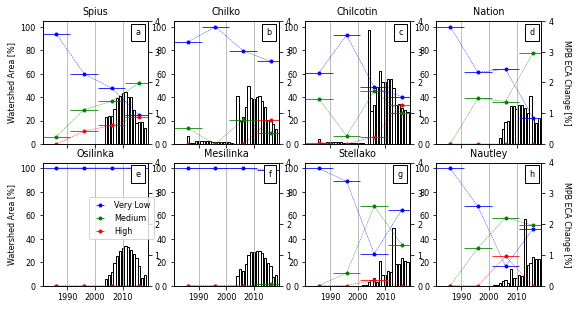

In [12]:
#supress warnings
import warnings
warnings.filterwarnings("ignore")


#---------------------------------------user defined variables--------------------------------------------
path='D:/UNBC/HydroMet_Project/Data/ERA5_land/'
Watersheds=['Spius','Chilko','Chilcotin','Nation','Osilinka','Mesilinka','Stellako','Nautley']
years=np.arange(1981,2018)
Counts=10 #defines number of years per analysis group 

#breaks data into timespans of choice (based on selection of Counts)
Breaks= chunks(years,Counts)

#------------------------------------------Initilize Plotting---------------------------------------------
#used for labeling of plot
L=['a','b','c','d','e','f','g','h']

# used for defining subplot for plotting
xi=[0,0,0,0,1,1,1,1]
yi=[0,1,2,3,0,1,2,3]

#initilize subplots for results display
fig,ax=plt.subplots(2,4,figsize=cm2inch(22,11),sharex=True)
fig.subplots_adjust(bottom=0.1, top=0.95, hspace=0.15, left=0.1, right=0.9, wspace=0.25)
font = {'family' : 'sans-serif', 'weight' : 'normal',  'size'   : 8}
plt.rc('font', **font)


#-------------------------------------Analysis--------------------------------------------------
for c, WS in enumerate(Watersheds):
    A=[]; M1=[]
    
    #initilize results dataframe
    Results=pd.DataFrame({'WS':[],'YearMin':[],'YearMax':[],'Very Low':[],'Low':[],'Medium':[],
                        'High':[],'Extreme':[]})
    
    #run all break subsets
    for years in Breaks:
        HOLD=[]; P_TOT_HOLD=[]
        
        #run through all years in break subset
        for Year in years:
            
            #load results for constraints C1 through C4 (calculated in Calculating_Constraints.ipynb)
            C1= np.load(path+'MPB_Constraints/%s/P1/%s.npy'%(WS,Year))[0]
            C2_OLD= np.load(path+'MPB_Constraints/%s/P2/%s.npy'%(WS,Year))[0]
            C3= np.load(path+'MPB_Constraints/%s/P3/%s.npy'%(WS,Year))[0]
            C4= np.load(path+'MPB_Constraints/%s/P4/%s.npy'%(WS,Year))[0]


            # Change C2_old  into binary array
            C2=np.empty([np.shape(C2_OLD)[0],np.shape(C2_OLD)[1]])
            for i in range(np.shape(C2_OLD)[0]):
                for j in range(np.shape(C2_OLD)[1]):
                    
                    # if there is 1 or zero days during a year with temps below -40 -->  True
                    if C2_OLD[i][j]<2:
                        C2[i][j]=1
                    
                    # else false
                    else:
                        C2[i][j]=0
                        
            # Sum all binary arrays together
            P=[C1,C2,C3,C4]
            P_Tot=np.nansum(P,axis=0)
            
            #determine where arrays are nan
            NAN= np.where(np.isnan(C1))
    

            # create a binary array for sum of constraints C1 through C4
            Shape= np.shape(P_Tot)
            Binary=np.empty([Shape[0],Shape[1]])
            for i in np.arange(0,Shape[0]):
                for j in np.arange(0, Shape[1]):
                    
                    # if sum of C1 to C4 =4 --> all constraints are met for a given year --> true
                    if P_Tot[i][j]==4:
                        Binary[i][j]=1
                        
                    # if three or less of the constraints are met for a given year -->  false
                    else:
                        Binary[i][j]=0
            
            # save each years binary array results
            P_TOT_HOLD.append(P_Tot)
            HOLD.append(Binary)

        #calculate the Aridity for each year
        Arid= Aridity(path,WS,years)
        A.append(Arid)
        
        # calculate growing season precip and create a raster
        GrowingSeasonPrecip('D:/UNBC/HydroMet_Project/Data/ERA5_land/',WS,years)
        RasterGrowingSeason('D:/UNBC/HydroMet_Project/Data/ERA5_land/MPB_Constraints/',WS,years)
        
        #Snip growing season precipitation raster to watershed
        GSP=Snip_Vari('D:/UNBC/HydroMet_Project/Data/ERA5_land/MPB_Constraints/',WS,years)[0]

        
        #Calculate the number of consecitive years where C1-C4 is true by grid cell
        HOLD=np.array(HOLD)
        Shape=np.shape(HOLD)
        Num_Consec=np.empty([Shape[1],Shape[2]])
        for i in range(Shape[1]):
            for j in range (Shape[2]):
                Work= HOLD[:,i,j]

                C= consec(Work)
                Num_Consec[i][j]=C

        # Determine X1 and X2 for each grid cell  and then calculate the f values that will equate to MPB CSC        
        Num_Consec= np.array(Num_Consec)
        Shape=np.shape(Num_Consec)
        f=np.empty([Shape[0],Shape[1]])
        for i in range(Shape[0]):
            for j in range(Shape[1]):
                X2= Arid_Index(Arid[i][j])
                X1= CV_Index(GSP[i][j])
                H=(Num_Consec[i][j]/len(years))*np.sqrt(X2*X1)
                f[i][j]=H

        #mask values in f that are not in the watershed
        for i in range(len(NAN[0])):
            j= NAN[0][i]
            k= NAN[1][i]
            f[j,k] =np.nan

        #extract all values that are within the watershed (those that aren't NAN)
        size= np.shape(f)[0]*np.shape(f)[1]
        Masked= len(np.where(np.isnan(f))[0])
        Area= size-Masked
      
        #calculate the percent area that falls within each CSC 
        VeryLow=len(np.where(f==0)[0])/Area*100
        Low=len(np.where((f>0) & (f<=0.05))[0])/Area*100
        Medium= len(np.where((f>0.05) & (f<=0.15))[0])/Area*100
        High= len(np.where((f>0.15) & (f<=0.35))[0])/Area*100
        Extreme= len(np.where(f>0.35)[0])/Area*100
        
        
        #Record the results
        Tot=np.sum([VeryLow,Low,Medium, High,Extreme])
        Results=Results.append({'WS':WS,'YearMin':int(min(years)),'YearMax':int(max(years)),'Very Low':VeryLow,'Low':Low,'Medium':Medium,
                                'High':High,'Extreme':Extreme,'Total':Tot},ignore_index=True)

    #---------------------------- Plotting Results -------------------------------------------------------
    x=xi[c];y=yi[c]
    Names= ['Very Low','Medium','High']
    colors=['b','g','r']
    count=0
    TB=pd.read_excel('D:/UNBC/HydroMet_Project/Data/Forest_Disturbance/ECA.xlsx',sheet_name=WS)

    #lenght of error bars
    e = np.repeat(Counts/2, len(Results.YearMin))

    ax1=ax[x,y].twinx()
    for N in Names:
        
        #plot error bars
        ax[x,y].errorbar(Results.YearMin+(Counts/2),Results[N],xerr=e,color=colors[count],label=Names[count],fmt='o',elinewidth=.8,markersize=3)
        
        #plot general trend
        ax[x,y].plot(Results.YearMin+(Counts/2),Results[N], color=colors[count],linestyle='--',linewidth=.4)
        count=count+1

    #plot MPB severity
    ax1.bar(TB.Year,TB.Delta_MPB, color='w',edgecolor='k')
    
    # setting plot features
    ax[x,y].grid(axis='x')
    ax1.set_ylim(0,4)
    ax[x,y].set_ylim(0,105)
    ax1.set_xlim(1981,2019)
    
    if (x==1)&(y==0):
        ax[x,y].legend(bbox_to_anchor=[.4,.35])
    if y==0:
        ax[x,y].set_ylabel('Watershed Area [%]')
    if y==3:
        ax1.set_ylabel('MPB ECA Change [%]', rotation=-90,labelpad=17)
    ax[x,y].set_title(WS)
    
    ax[x,y].set_zorder(1)
    ax[x,y].patch.set_visible(False)
    
    #set plot labels
    at = AnchoredText(L[c], frameon=True, loc='upper right')
    at.patch.set_boxstyle("Square,pad=0.15")
    ax[x,y].add_artist(at)
    
# save figure (figure 7)
Path_Figs='C:/Users/margo.DESKTOP-T66VM01/Desktop/UNBC/Writting_Drafts/Manuscripts_for_submission/Figures/'
fig.savefig(Path_Figs+'Fig6.pdf',dpi=700)


### Limiting constraints of MPB model

In [4]:
P1_Count=[];P2_Count=[];P3_Count=[];P4_Count=[];
path='D:/UNBC/HydroMet_Project/Data/ERA5_land/'
#choose 1 watershed
WS='Mesilinka'

#loop through all years
for Year in np.arange(1981,2017):
    
    #load all constraints
    P1= np.load(path+'MPB_Constraints/%s/P1/%s.npy'%(WS,Year))[0]
    P2_OLD= np.load(path+'MPB_Constraints/%s/P2/%s.npy'%(WS,Year))[0]
    P3= np.load(path+'MPB_Constraints/%s/P3/%s.npy'%(WS,Year))[0]
    P4= np.load(path+'MPB_Constraints/%s/P4/%s.npy'%(WS,Year))[0]
    
    #convert P2 into a binary array
    P2=np.empty([np.shape(P2_OLD)[0],np.shape(P2_OLD)[1]])
    for i in range(np.shape(P2_OLD)[0]):
        for j in range(np.shape(P2_OLD)[1]):
            if P2_OLD[i][j]<1:
                P2[i][j]=1
            else:
                P2[i][j]=0
      
    #determine the area size 
    size= np.shape(P3)[0]*np.shape(P3)[1]
    Masked= len(np.where(np.isnan(P3))[0])
    Area= size-Masked
    
    # %area of each constraint for each year
    P1_Count.append(len(np.where(P1==1)[0])/Area*100)
    P2_Count.append(len(np.where(P2==1)[0])/Area*100)
    P3_Count.append(len(np.where(P3==1)[0])/Area*100)
    P4_Count.append(len(np.where(P4==1)[0])/Area*100)
    

C:\Anaconda3\envs\Trial\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


Text(0, 0.5, 'P4- Growing Season Precip')

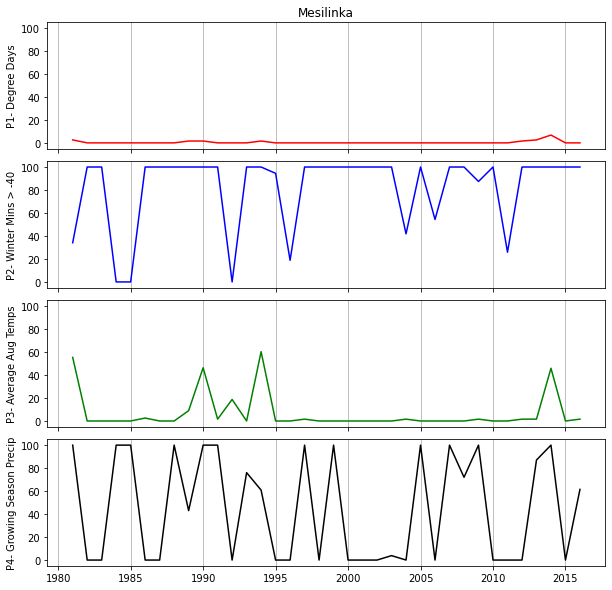

In [5]:
## Plotting each constraint to see where the limitiaions are

#initilize plots
fig,ax=plt.subplots(4,figsize=(10,10),sharex=True)
plt.subplots_adjust(left=None, bottom=None , right=None, top=None, wspace=.1, hspace=.1)

#plotting C1
ax[0].plot(np.arange(1981,2017),P1_Count, color='r')
ax[0].grid(axis='x')
ax[0].set_ylim(-5,105)
ax[0].set_ylabel('C1- Degree Days')
ax[0].set_title(WS)

#Plotting C2
ax[1].plot(np.arange(1981,2017),P2_Count, color='b')
ax[1].grid(axis='x')
ax[1].set_ylim(-5,105)
ax[1].set_ylabel('C2- Winter Mins > -40')

#Plotting C3
ax[2].plot(np.arange(1981,2017),P3_Count, color='g')
ax[2].grid(axis='x')
ax[2].set_ylim(-5,105)
ax[2].set_ylabel('C3- Average Aug Temps')

#Plotting C4
ax[3].plot(np.arange(1981,2017),P4_Count, color='k')
ax[3].grid(axis='x')
ax[3].set_ylim(-5,105)
ax[3].set_ylabel('C4- Growing Season Precip')
